In [264]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from pmdarima import auto_arima
import requests
from fredapi import Fred
import seaborn as sns

In [ ]:
#This format was used to call the Fred api to obtain CPI and Brent crude oil price data
# fred_key = '*Your fred key*'
# fred = Fred(api_key = fred_key)
# fred

# x = pd.DataFrame(fred.get_series(series_id='*ID of data you want*'),columns=['Rename it to what you want'])
# x.index.name = "Date"

# x.to_csv('*file to store in*')

In [190]:
# Section 1 #########################################################################################
#Handles stock_Data

In [191]:
#Stage 1: Aquiring historical stock data of Apple + initial cleaning from yfinance api
tickerSymbol = 'AAPl' 
tickerData = yf.Ticker(tickerSymbol)
stockData = tickerData.history(interval='1d',start='2017-4-1',end='2022-6-1',)
stockData.index = stockData.index.tz_localize(None)
stockData

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03,33.768534,33.864872,33.613448,33.766182,79942800,0.0,0.0
2017-04-04,33.660454,34.045816,33.641655,34.017620,79565600,0.0,0.0
2017-04-05,33.888376,34.179748,33.792034,33.841381,110871600,0.0,0.0
2017-04-06,33.904827,33.958874,33.707447,33.756794,84596000,0.0,0.0
2017-04-07,33.773224,33.878963,33.665137,33.681583,66688800,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-24,140.381810,141.538287,136.912397,139.933182,104132700,0.0,0.0
2022-05-25,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0
2022-05-26,136.972206,143.901068,136.722966,143.342773,90601500,0.0,0.0


In [192]:
#Stage 2: resampling data and interpolating missing values 
stockDataResample = pd.DataFrame(stockData.resample('1d').sum())
stockDataResample[stockDataResample == 0] = None
stockDataResample = stockDataResample.interpolate(method='pad')
stockDataResample = np.log(stockDataResample)
stockDataResample



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03,3.519529,3.522378,3.514926,3.519460,18.196822,NaN,NaN
2017-04-04,3.516324,3.527707,3.515765,3.526879,18.192092,NaN,NaN
2017-04-05,3.523072,3.531633,3.520225,3.521684,18.523883,NaN,NaN
2017-04-06,3.523557,3.525150,3.517719,3.519182,18.253398,NaN,NaN
2017-04-07,3.519668,3.522794,3.516463,3.516951,18.015548,NaN,NaN
...,...,...,...,...,...,...,...
2022-05-27,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294
2022-05-28,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294
2022-05-29,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294


In [193]:
#Stage 3: Working out first difference
stockDataResample['FirstDifference'] = stockDataResample['Close'].diff().fillna(0)  
stockDataResample = stockDataResample.fillna(0)  

In [194]:
stockDataResample.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,4.256165,4.266605,4.245461,4.256466,18.525406,-1.623212,0.469943,0.000785
std,0.549584,0.550864,0.548065,0.549708,0.410695,0.259147,0.656400,0.016450
min,3.502051,3.506714,3.493803,3.498220,17.529083,-1.848330,0.000000,-0.137708
25%,3.743433,3.752285,3.737246,3.746583,18.228488,-1.701005,0.000000,-0.003056
50%,4.087782,4.099656,4.071882,4.084307,18.470976,-1.647659,0.000000,0.000000
75%,4.831652,4.841098,4.821250,4.829100,18.775717,-1.584745,1.386294,0.006317
max,5.201675,5.203371,5.182269,5.198275,19.871146,0.000000,1.386294,0.113158


Text(0.5, 0, 'Lags')

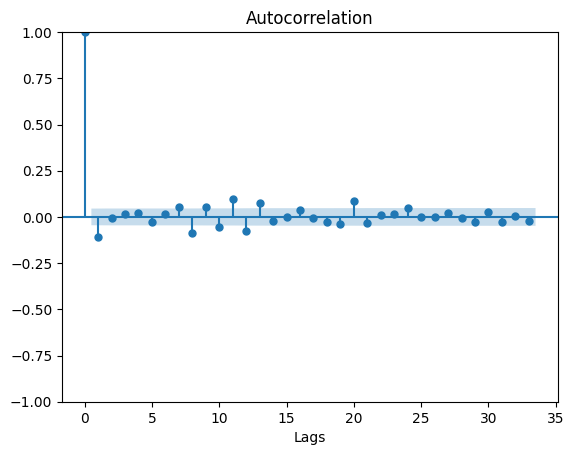

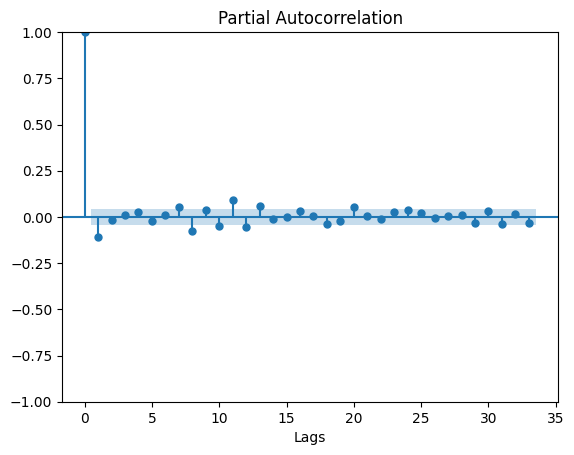

In [195]:
acf_plot = plot_acf(stockDataResample['FirstDifference'] )
plt.xlabel("Lags")
pacf_plot = plot_pacf(stockDataResample['FirstDifference'] )
plt.xlabel("Lags")

In [196]:
# Section 2 #########################################################################################
#Handles Federal Reserve Discount Rate

In [197]:
#Stage 1: Aquiring historical rates from federal reserve + initial cleaning
frData=pd.read_csv('src/FRB_H15.csv')
frData.columns = ['Date','Federal funds Rate','Prime Rate','Discount Rate']
frData = frData[5:]
frData = frData.reset_index(drop=True)
frData = frData.set_index('Date')
frData.index = pd.to_datetime(frData.index)
frData = frData.astype({'Discount Rate': 'float','Prime Rate': 'float','Federal funds Rate': 'float'})

In [198]:
#Stage 2: Resampling data and interpolating missing values 
frDataResample = pd.DataFrame(frData.resample('1d').sum())
frDataResample[frDataResample == 0] = None
frDataResample = frDataResample.interpolate(method='time') 
frDataResample = pd.DataFrame(frDataResample['2017-04-03':'2022-05-31'])
frDataResample

,Federal funds Rate,Prime Rate,Discount Rate
Date,,,
2017-04-03,0.881429,4.0,1.5
2017-04-04,0.875714,4.0,1.5
2017-04-05,0.870000,4.0,1.5
2017-04-06,0.875714,4.0,1.5
2017-04-07,0.881429,4.0,1.5
...,...,...,...
2022-05-27,0.830000,4.0,1.0
2022-05-28,0.830000,4.0,1.0
2022-05-29,0.830000,4.0,1.0


In [219]:
#Null Checks
frDataResample.isnull().values.any()

False

In [199]:
# Section 3 #########################################################################################
#Handles CPI Index Data

In [200]:
#Stage 1: Retrieving stored Historical CPI data originally obtained from Fred Api + initial cleaning
conPiData = pd.read_csv('src/USA_CPI_Index.csv')
conPiData = conPiData.reset_index(drop=True)
conPiData = conPiData.set_index('Date')
conPiData.index = pd.to_datetime(conPiData.index)
conPiData = conPiData.astype({'CPI Index': 'float'})

In [201]:
#Stage 2: Resampling data and interpolating missing values for cpi data
conPiDataResample = pd.DataFrame(conPiData.resample('1d').sum())
conPiDataResample[conPiDataResample == 0] = None
conPiDataResample = conPiDataResample.interpolate(method='time') 
conPiDataResample = pd.DataFrame(conPiDataResample['2017-04-03':'2022-05-31'])
conPiDataResample

,CPI Index
Date,
2017-04-03,244.180400
2017-04-04,244.174100
2017-04-05,244.167800
2017-04-06,244.161500
2017-04-07,244.155200
...,...
2022-05-27,294.706387
2022-05-28,294.830710
2022-05-29,294.955032


In [217]:
#Null Checks
conPiDataResample.isnull().values.any()

False

In [202]:
# Section 4 #########################################################################################
#Handles Brent Crude Oil prices Data

In [203]:
#Stage 1: Retrieving stored Historical Brent Crude Oil data originally obtained from Fred Api + initial cleaning
OilData = pd.read_csv('src/USA_BrentCrudeOil.csv')
OilData = OilData.reset_index(drop=True)
OilData = OilData.set_index('Date')
OilData.index = pd.to_datetime(OilData.index)
OilData = OilData.astype({'CrudeOil Price': 'float'})

In [204]:
#Stage 2: resampling data and interpolating missing values 
OilDataResample = pd.DataFrame(OilData.resample('1d').sum())
OilDataResample[OilDataResample == 0] = None
OilDataResample = OilDataResample.interpolate(method='time') 
OilDataResample = pd.DataFrame(OilDataResample['2017-04-03':'2022-05-31'])
OilDataResample

,CrudeOil Price
Date,
2017-04-03,52.040000
2017-04-04,53.080000
2017-04-05,53.410000
2017-04-06,53.620000
2017-04-07,54.240000
...,...
2022-05-27,121.190000
2022-05-28,121.796667
2022-05-29,122.403333


In [218]:
#Null Checks
OilDataResample.isnull().values.any()

False

In [ ]:
# Section 6 #########################################################################################
#Cleaned Raw Data Visualisation

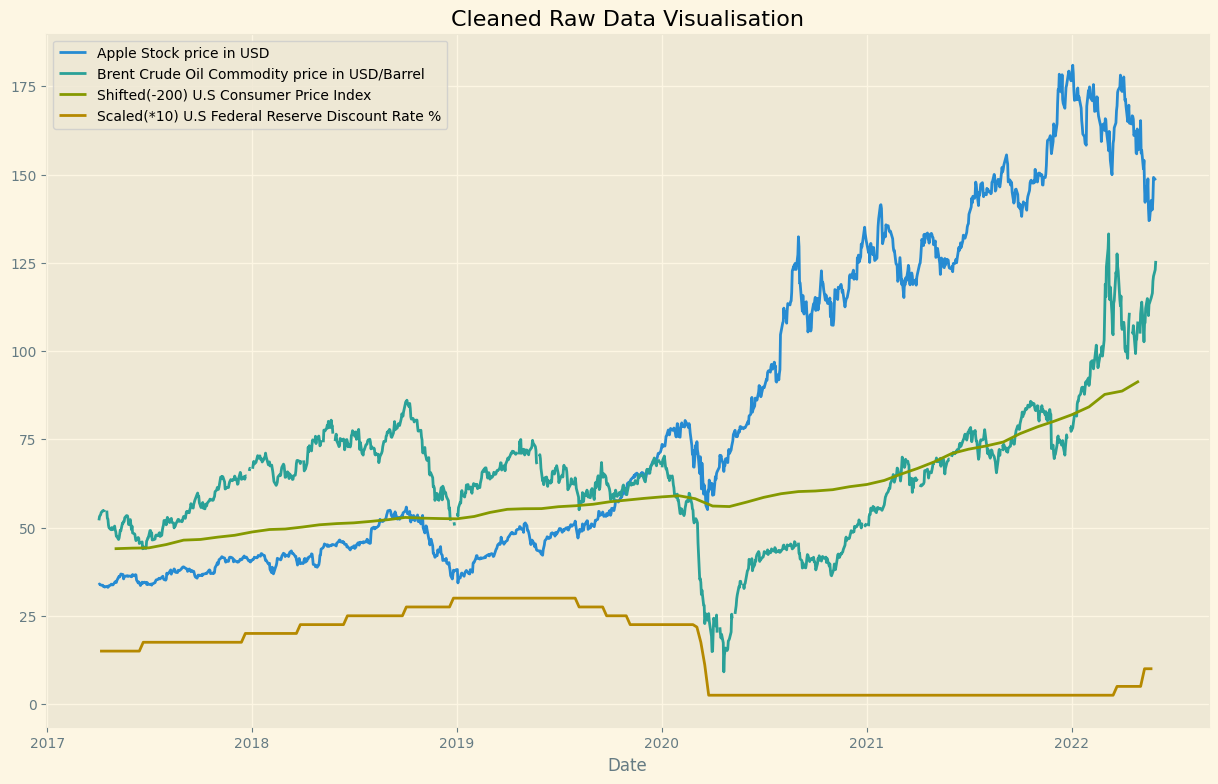

In [256]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))
plt.plot(stockData['Close']['2017-04-03':'2022-05-31'],label='Apple Stock price in USD')
plt.plot(OilData['2017-04-03':'2022-05-31'],label='Brent Crude Oil Commodity price in USD/Barrel')
plt.plot(conPiData['2017-04-03':'2022-05-31']-200,label='Shifted(-200) U.S Consumer Price Index')
plt.plot(frData['Discount Rate']['2017-04-03':'2022-05-31'] *10,label='Scaled(*10) U.S Federal Reserve Discount Rate %')

plt.legend()
plt.xlabel("Date")
plt.ylabel("")
plt.title("Cleaned Raw Data Visualisation")
plt.show()

In [205]:
# Section 6 #########################################################################################
#merging all exogenous variables/ Data Exploration####################

In [206]:
exogenousdf = pd.concat([np.log(conPiDataResample[['CPI Index']]),frDataResample[['Discount Rate']]], axis=1)
exogenousdf['CrudeOil Price'] = np.log(OilDataResample['CrudeOil Price'])
exogenousdf

,CPI Index,Discount Rate,CrudeOil Price
Date,,,
2017-04-03,5.497907,1.5,3.952013
2017-04-04,5.497881,1.5,3.971800
2017-04-05,5.497856,1.5,3.977998
2017-04-06,5.497830,1.5,3.981922
2017-04-07,5.497804,1.5,3.993419
...,...,...,...
2022-05-27,5.685980,1.0,4.797360
2022-05-28,5.686401,1.0,4.802353
2022-05-29,5.686823,1.0,4.807322


In [207]:
exogenousdf.describe()

,CPI Index,Discount Rate,CrudeOil Price
count,1885.000000,1885.000000,1885.000000
mean,5.558859,1.462218,4.118064
std,0.045603,1.080834,0.315678
min,5.497185,0.250000,2.210470
25%,5.527668,0.250000,3.977998
50%,5.547871,1.750000,4.165890
75%,5.576430,2.500000,4.289774
max,5.687666,3.000000,4.891702


[Text(0.5, 1.0, 'HeatMap of Correlations between Exogenous Variables')]

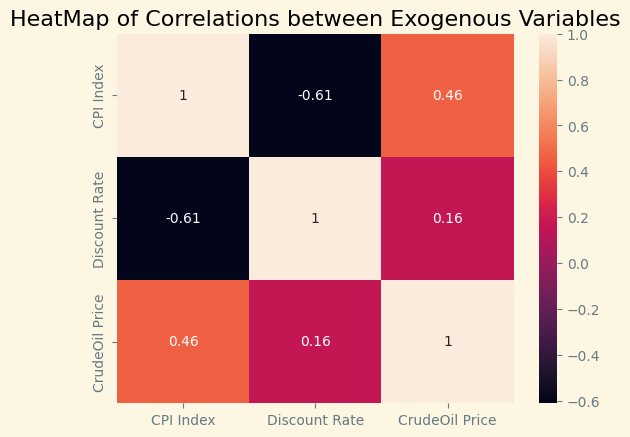

In [258]:
c = exogenousdf.corr()
sns.heatmap(c,annot=True).set(title='HeatMap of Correlations between Exogenous Variables')

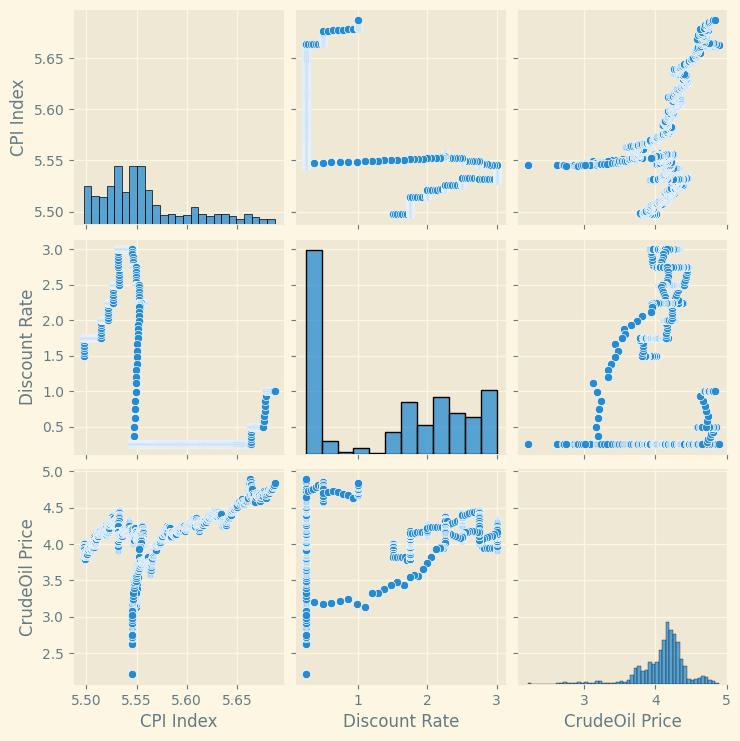

In [260]:
sns.pairplot(exogenousdf)

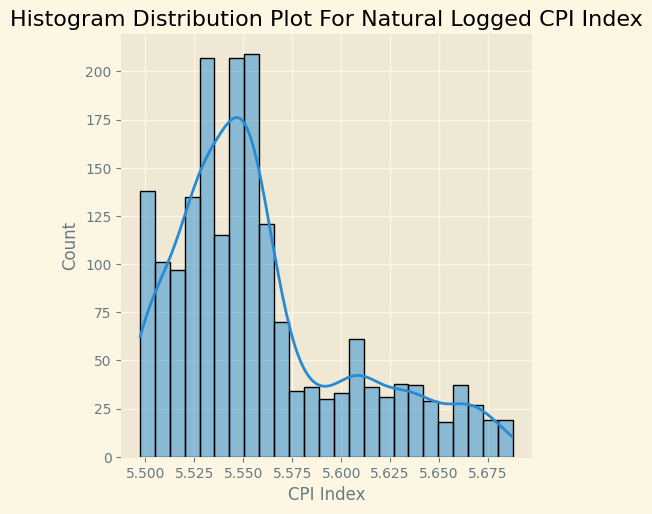

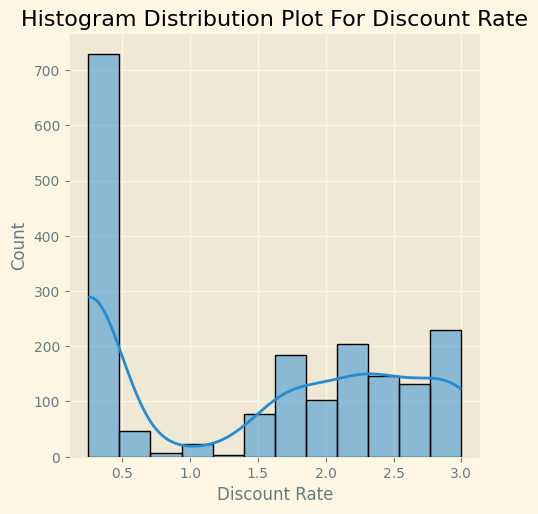

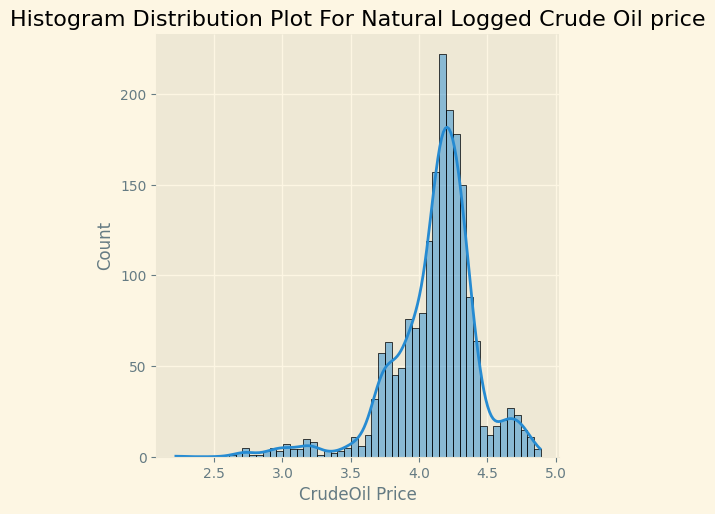

In [262]:
sns.displot(exogenousdf['CPI Index'],kde=True).set(title='Histogram Distribution Plot For Natural Logged CPI Index')
sns.displot(exogenousdf['Discount Rate'],kde=True).set(title='Histogram Distribution Plot For Discount Rate')
sns.displot(exogenousdf['CrudeOil Price'],kde=True).set(title='Histogram Distribution Plot For Natural Logged Crude Oil price')

In [ ]:
#Hypothesis testing Section

In [211]:
stepwise_fit = auto_arima(stockDataResample['Close'],trace=False,suppress_warnings=False )
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5076.666
Date:                Thu, 26 Jan 2023   AIC                         -10147.331
Time:                        10:18:35   BIC                         -10130.708
Sample:                    04-03-2017   HQIC                        -10141.209
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      2.288      0.022       0.000       0.001
ma.L1         -0.1110      0.015     -7.294      0.000      -0.141      -0.081
sigma2         0.0003    3.7e-06     72.150      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7190.56
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [212]:
stepwise_fit = auto_arima(stockDataResample['Close'], X = exogenousdf[['Discount Rate']],trace=False,suppress_warnings=False )
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5077.393
Date:                Thu, 26 Jan 2023   AIC                         -10146.786
Time:                        10:18:37   BIC                         -10124.622
Sample:                    04-03-2017   HQIC                        -10138.623
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0008      0.000      2.241      0.025    9.87e-05       0.001
Discount Rate     0.0320      0.011      3.028      0.002       0.011       0.053
ma.L1            -0.1113      0.016     -6.782      0.000      -0.144      -0.079
sigma2            0.0003   3.83e-06     69.795      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6918.25
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
stepwise_fit = auto_arima(stockDataResample[['Close']], X = exogenousdf[['CPI Index']],trace=False,suppress_warnings=False )
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(5, 2, 1)   Log Likelihood                5065.973
Date:                Thu, 26 Jan 2023   AIC                         -10115.945
Time:                        10:23:26   BIC                         -10071.620
Sample:                    04-03-2017   HQIC                        -10099.620
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI Index      9.4152      3.905      2.411      0.016       1.761      17.069
ar.L1         -0.1187      0.017     -7.170      0.000      -0.151      -0.086
ar.L2          0.0148      0.019      0.761      0.447      -0.023       0.053
ar.L3          0.0051      0.017      0.304      0.761      -0.028       0.038
ar.L4          0.0102      0.019      0.525      0.599      -0.028       0.048
ar.L5         -0.0499      0.019     -2.657      0.008      -0.087      -0.013
ma.L1         -0.9864      0.004   -222.656      0.000      -0.995      -0.978
sigma2         0.0003   3.95e-06     67.654      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7123.13
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
stepwise_fit = auto_arima(stockDataResample['Close'], X = exogenousdf[['CrudeOil Price']],trace=False,suppress_warnings=False )
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5096.575
Date:                Thu, 26 Jan 2023   AIC                         -10185.149
Time:                        10:18:56   BIC                         -10162.985
Sample:                    04-03-2017   HQIC                        -10176.986
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0007      0.000      2.194      0.028    7.91e-05       0.001
CrudeOil Price     0.0819      0.010      8.516      0.000       0.063       0.101
ma.L1             -0.1119      0.016     -7.050      0.000      -0.143      -0.081
sigma2             0.0003   3.85e-06     67.936      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6448.14
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [263]:
stepwise_fit = auto_arima(stockDataResample['Close'], X = exogenousdf,trace=False,suppress_warnings=False )
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5095.981
Date:                Thu, 26 Jan 2023   AIC                         -10179.962
Time:                        11:08:09   BIC                         -10146.715
Sample:                    04-03-2017   HQIC                        -10167.718
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0005      0.000      1.148      0.251      -0.000       0.001
CPI Index          2.6488      2.685      0.987      0.324      -2.613       7.911
Discount Rate      0.0109      0.014      0.776      0.438      -0.017       0.038
CrudeOil Price     0.0800      0.010      7.843      0.000       0.060       0.100
ma.L1             -0.1112      0.017     -6.503      0.000      -0.145      -0.078
sigma2             0.0003   3.94e-06     66.452      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6301.37
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Section 7 #########################################################################################
#SARIMAX Predictive models####################

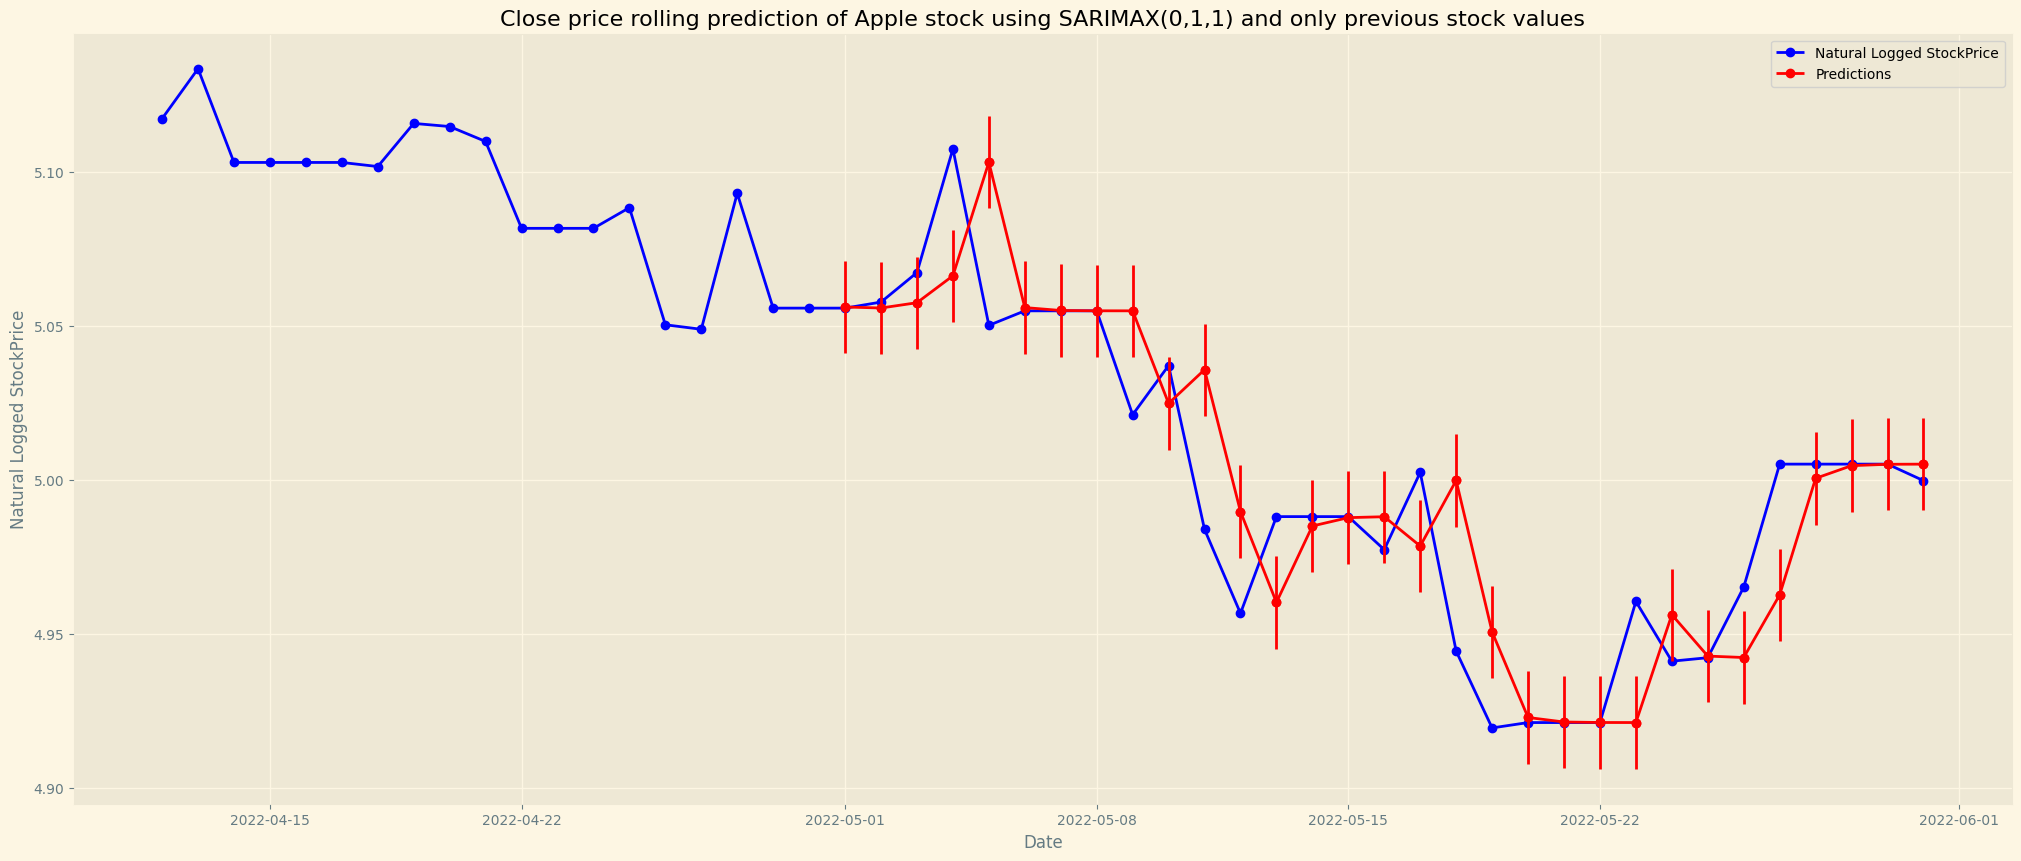

The root mean squared error is:  0.13914120716652387


In [286]:
#Close price rolling prediction of Apple stock using SARIMAX and only previous stock values
trainData = stockDataResample['Close'][0:1854]
testData = pd.DataFrame(stockDataResample['Close'][1854:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = SARIMAX(trainData,order=(0,1,1))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast()
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    
   
    
    
#plot for close price prediction
plt.figure(figsize=(25,10))
plt.plot(stockDataResample['Close'][1835:],'-bo',label='Natural Logged StockPrice')
plt.plot(testData['Predictions'],'-ro',label='Predictions')

plt.errorbar(x = testData.index, y = testData['Predictions'],
             yerr = 0.015,
             fmt ='ro')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Natural Logged StockPrice")
plt.title("Close price rolling prediction of Apple stock using SARIMAX(0,1,1) and only previous stock values")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))
predSave1 = testData
predSave1.columns = ['Close','No Exogenous Variables']

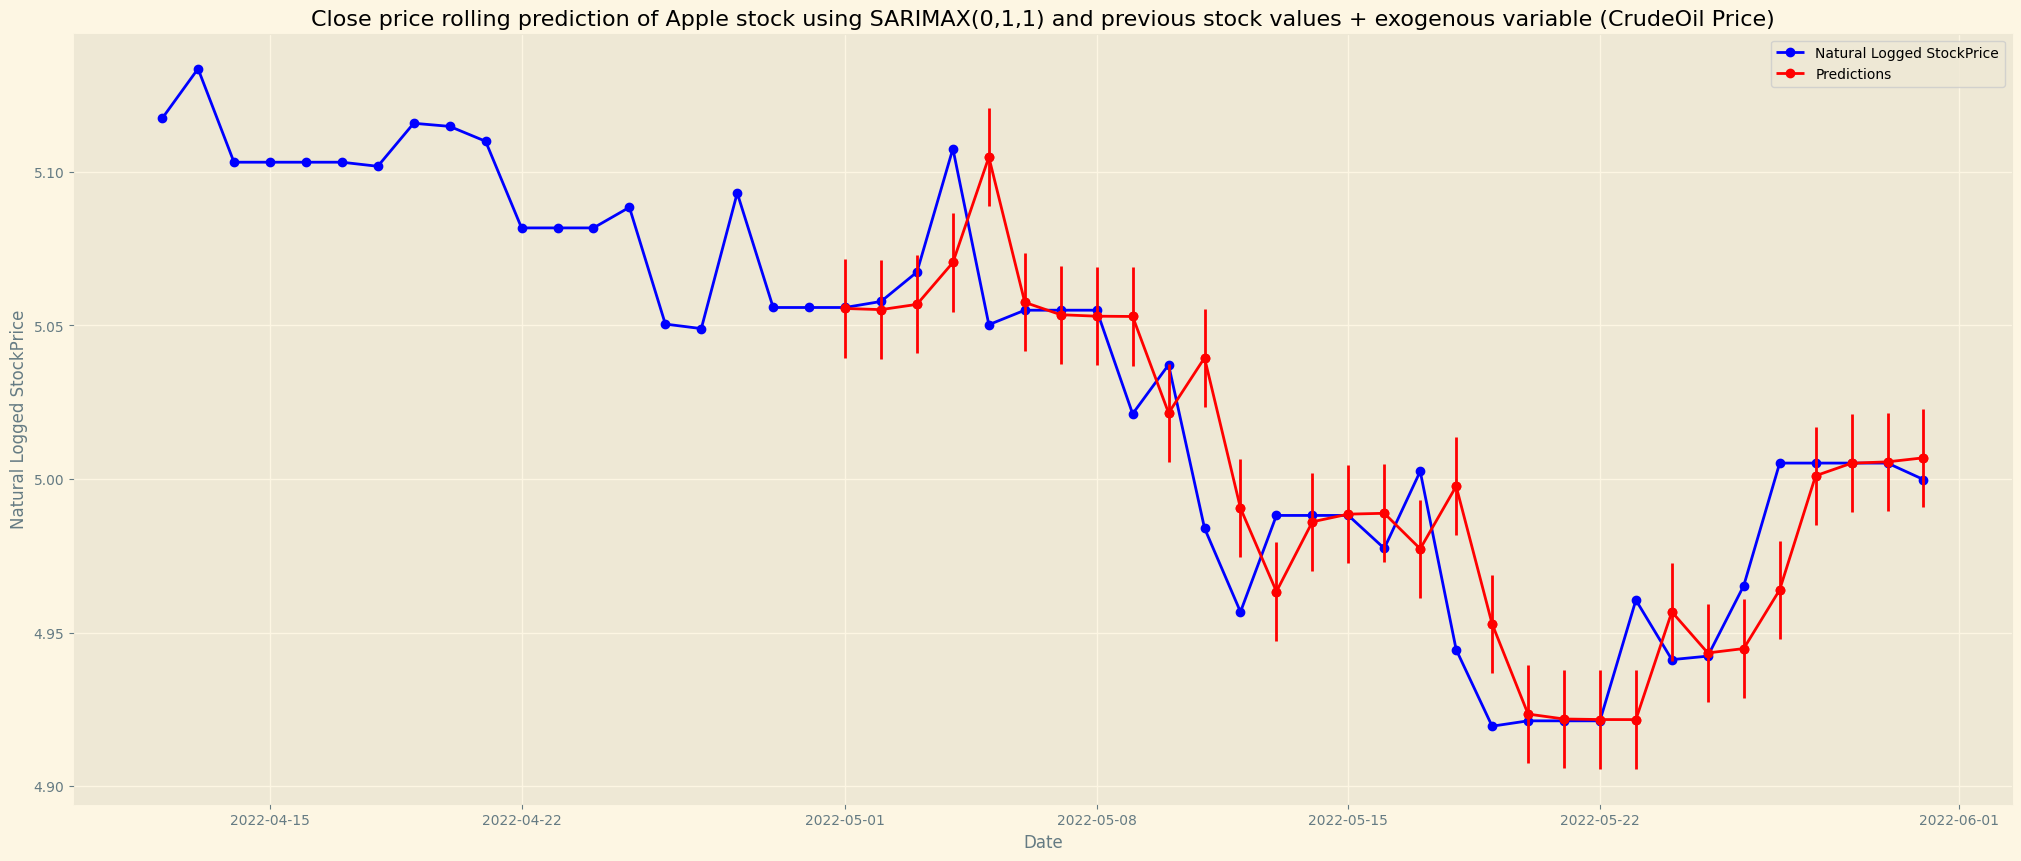

The root mean squared error is:  0.13871031573432804


In [293]:
#Close price rolling prediction of Apple stock using SARIMAX and previous stock values + exogenous variable (CrudeOil Price)

trainData = stockDataResample['Close'][0:1854]
trainDataExog = exogenousdf['CrudeOil Price'][0:1854]  
testData = pd.DataFrame(stockDataResample['Close'][1854:])
testDataExog =  pd.DataFrame(exogenousdf['CrudeOil Price'][1854:])   
testData['Predictions'] = 0

for i in range(len(testData)):
    model = SARIMAX(endog=trainData,exog=trainDataExog,order=(0, 1, 1))
    modelFit = model.fit()

    futureForcast = modelFit.forecast(exog = testDataExog['CrudeOil Price'][i:i+1])
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    trainDataExog = trainDataExog.append(testDataExog['CrudeOil Price'][i:i+1])
    trainDataExog = trainDataExog[1:] 
    
    
    
    
#plot for close price prediction
plt.figure(figsize=(25,10))
plt.plot(stockDataResample['Close'][1835:],'-bo',label='Natural Logged StockPrice')
plt.plot(testData['Predictions'],'-ro',label='Predictions')

plt.errorbar(x = testData.index, y = testData['Predictions'],
             yerr = 0.016,
             fmt ='ro')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Natural Logged StockPrice")
plt.title("Close price rolling prediction of Apple stock using SARIMAX(0,1,1) and previous stock values + exogenous variable (CrudeOil Price)")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))
predSave2 = testData

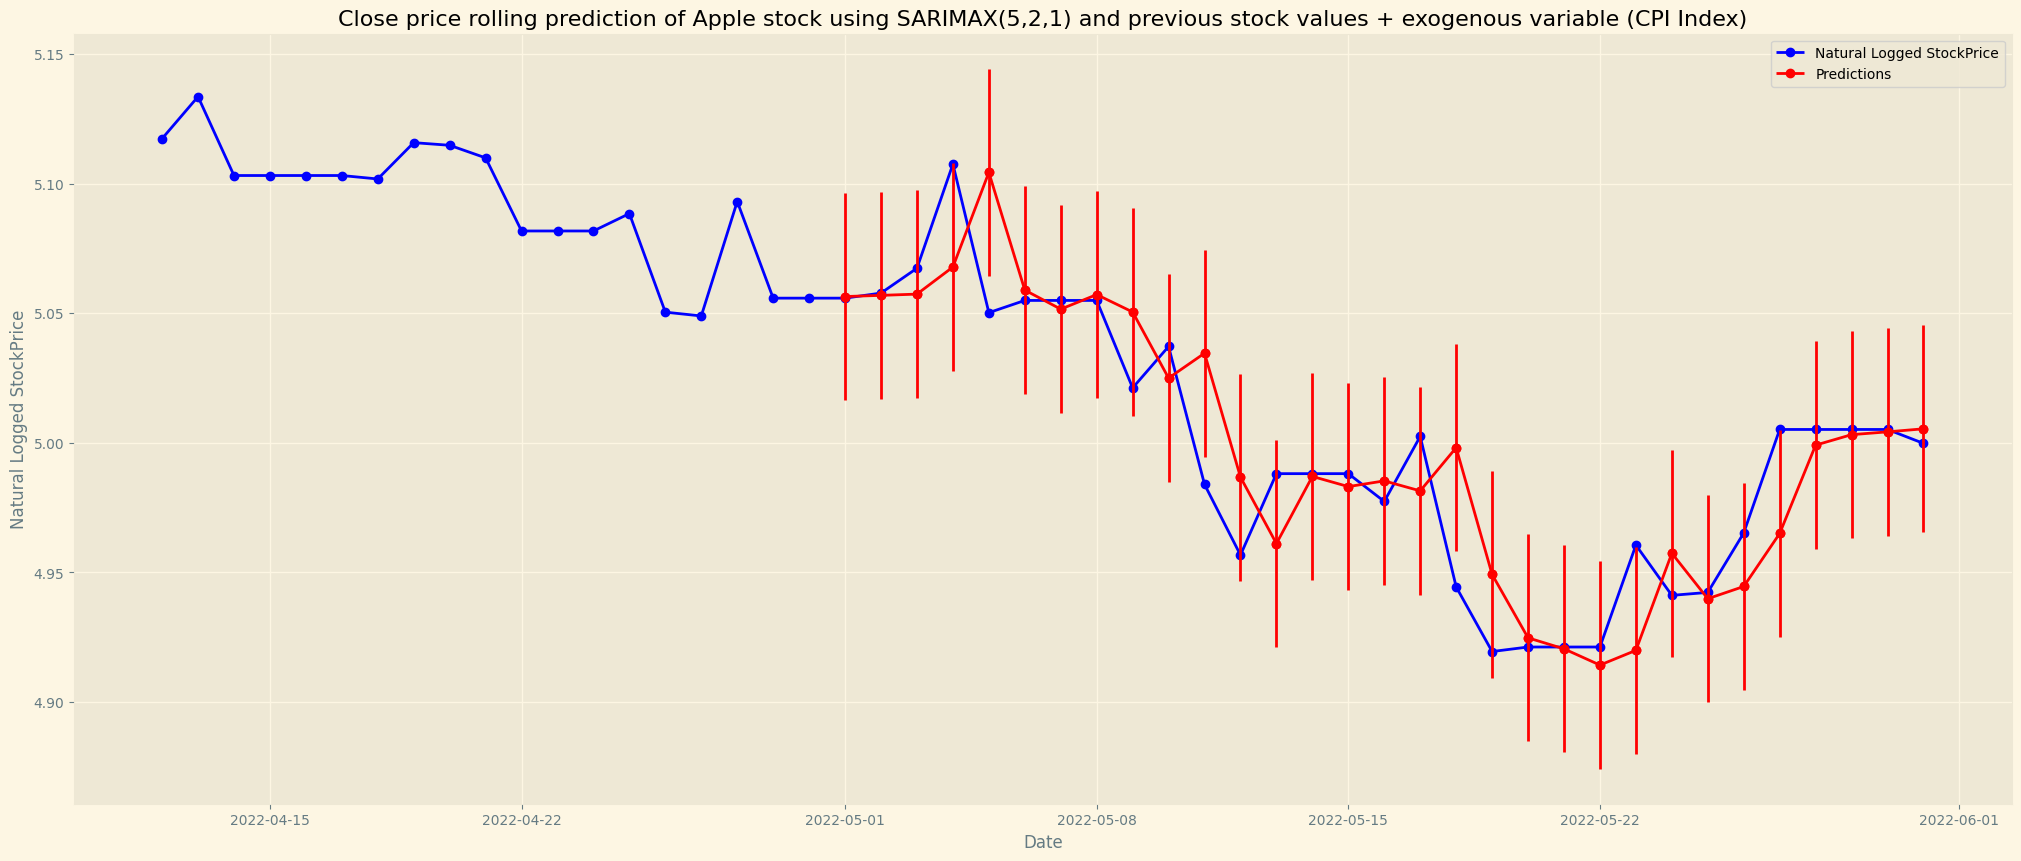

The root mean squared error is:  0.13505579764578104


In [294]:
#Close price rolling prediction of Apple stock using SARIMAX and previous stock values + exogenous variable (CPI Index)

trainData = stockDataResample['Close'][0:1854]
trainDataExog = exogenousdf['CPI Index'][0:1854]  
testData = pd.DataFrame(stockDataResample['Close'][1854:])
testDataExog =  pd.DataFrame(exogenousdf['CPI Index'][1854:])   
testData['Predictions'] = 0

for i in range(len(testData)):
    model = SARIMAX(endog=trainData,exog=trainDataExog,order=(5, 2, 1))
    modelFit = model.fit()

    futureForcast = modelFit.forecast(exog = testDataExog['CPI Index'][i:i+1])
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    trainDataExog = trainDataExog.append(testDataExog['CPI Index'][i:i+1])
    trainDataExog = trainDataExog[1:] 
    
    
    
    
#plot for close price prediction
plt.figure(figsize=(25,10))
plt.plot(stockDataResample['Close'][1835:],'-bo',label='Natural Logged StockPrice')
plt.plot(testData['Predictions'],'-ro',label='Predictions')

plt.errorbar(x = testData.index, y = testData['Predictions'],
             yerr = 0.04,
             fmt ='ro')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Natural Logged StockPrice")
plt.title("Close price rolling prediction of Apple stock using SARIMAX(5,2,1) and previous stock values + exogenous variable (CPI Index)")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))
predSave3 = testData

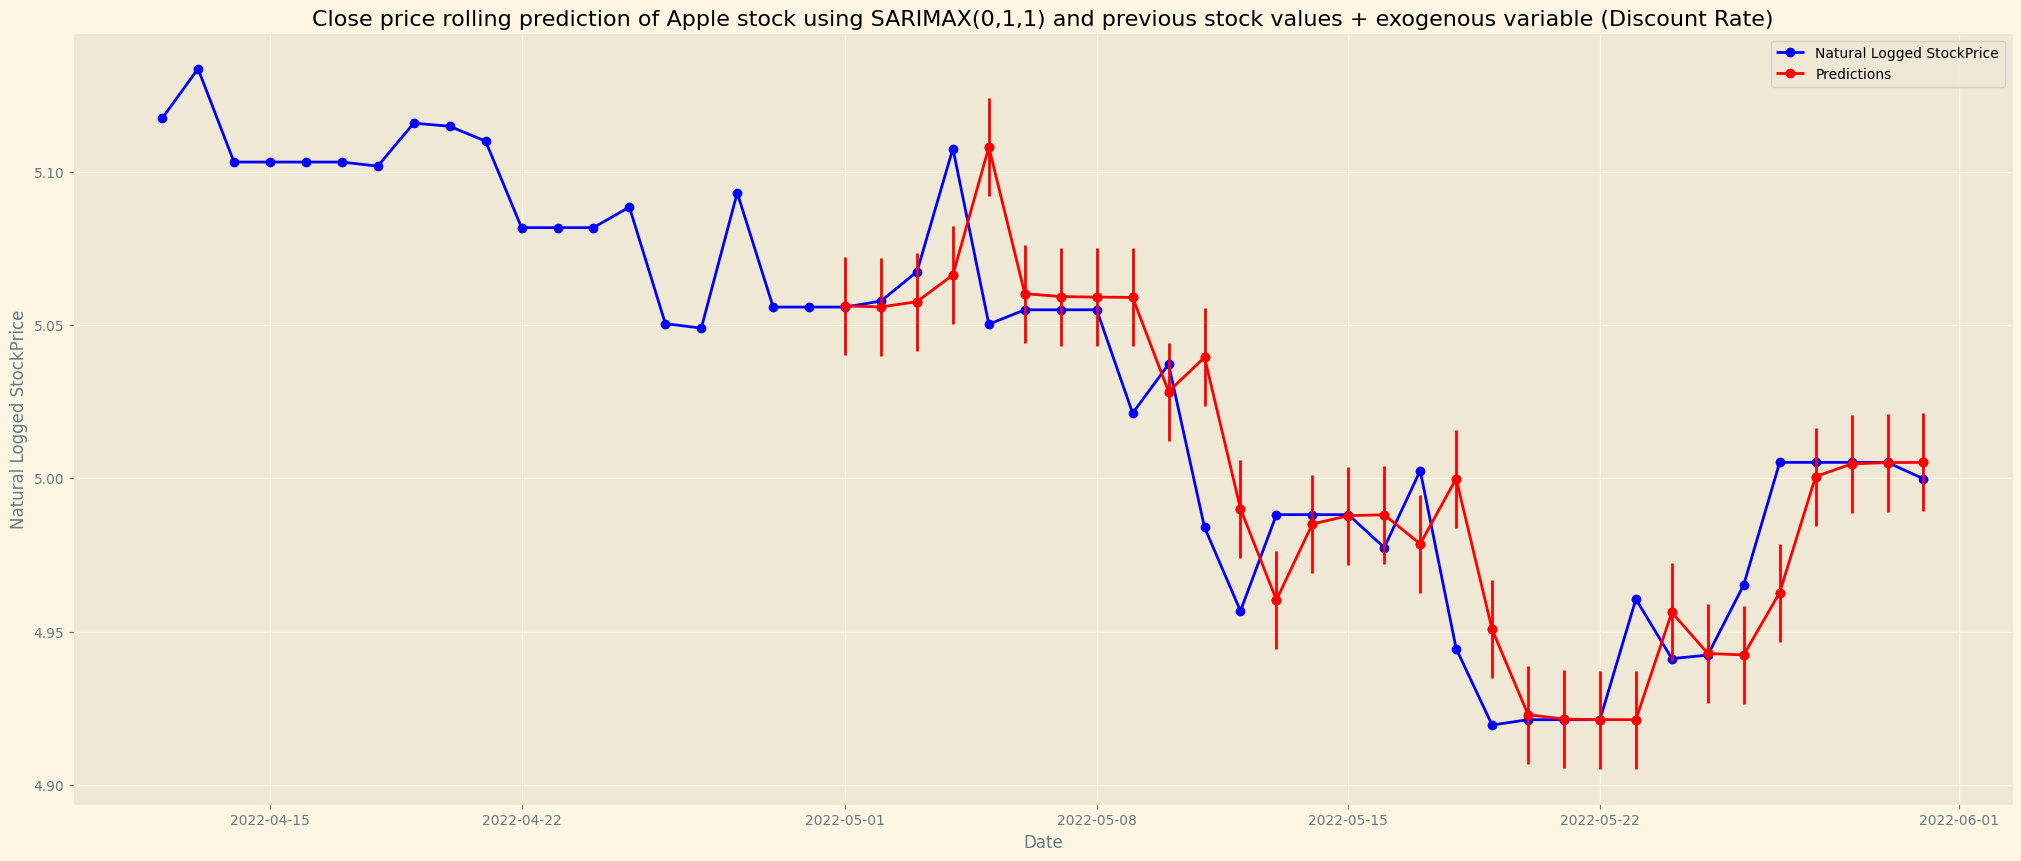

The root mean squared error is:  0.14344034627452087


In [296]:
#Close price rolling prediction of Apple stock using SARIMAX and previous stock values + exogenous variable (Discount Rate)

trainData = stockDataResample['Close'][0:1854]
trainDataExog = exogenousdf['Discount Rate'][0:1854]  
testData = pd.DataFrame(stockDataResample['Close'][1854:])
testDataExog =  pd.DataFrame(exogenousdf['Discount Rate'][1854:])   
testData['Predictions'] = 0

for i in range(len(testData)):
    model = SARIMAX(endog=trainData,exog=trainDataExog,order=(0, 1, 1))
    modelFit = model.fit()

    futureForcast = modelFit.forecast(exog = testDataExog['Discount Rate'][i:i+1])
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    trainDataExog = trainDataExog.append(testDataExog['Discount Rate'][i:i+1])
    trainDataExog = trainDataExog[1:] 
    
    
    
    
#plot for close price prediction
plt.figure(figsize=(25,10))
plt.plot(stockDataResample['Close'][1835:],'-bo',label='Natural Logged StockPrice')
plt.plot(testData['Predictions'],'-ro',label='Predictions')

plt.errorbar(x = testData.index, y = testData['Predictions'],
             yerr = 0.016,
             fmt ='ro')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Natural Logged StockPrice")
plt.title("Close price rolling prediction of Apple stock using SARIMAX(0,1,1) and previous stock values + exogenous variable (Discount Rate)")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))
predSave4 = testData

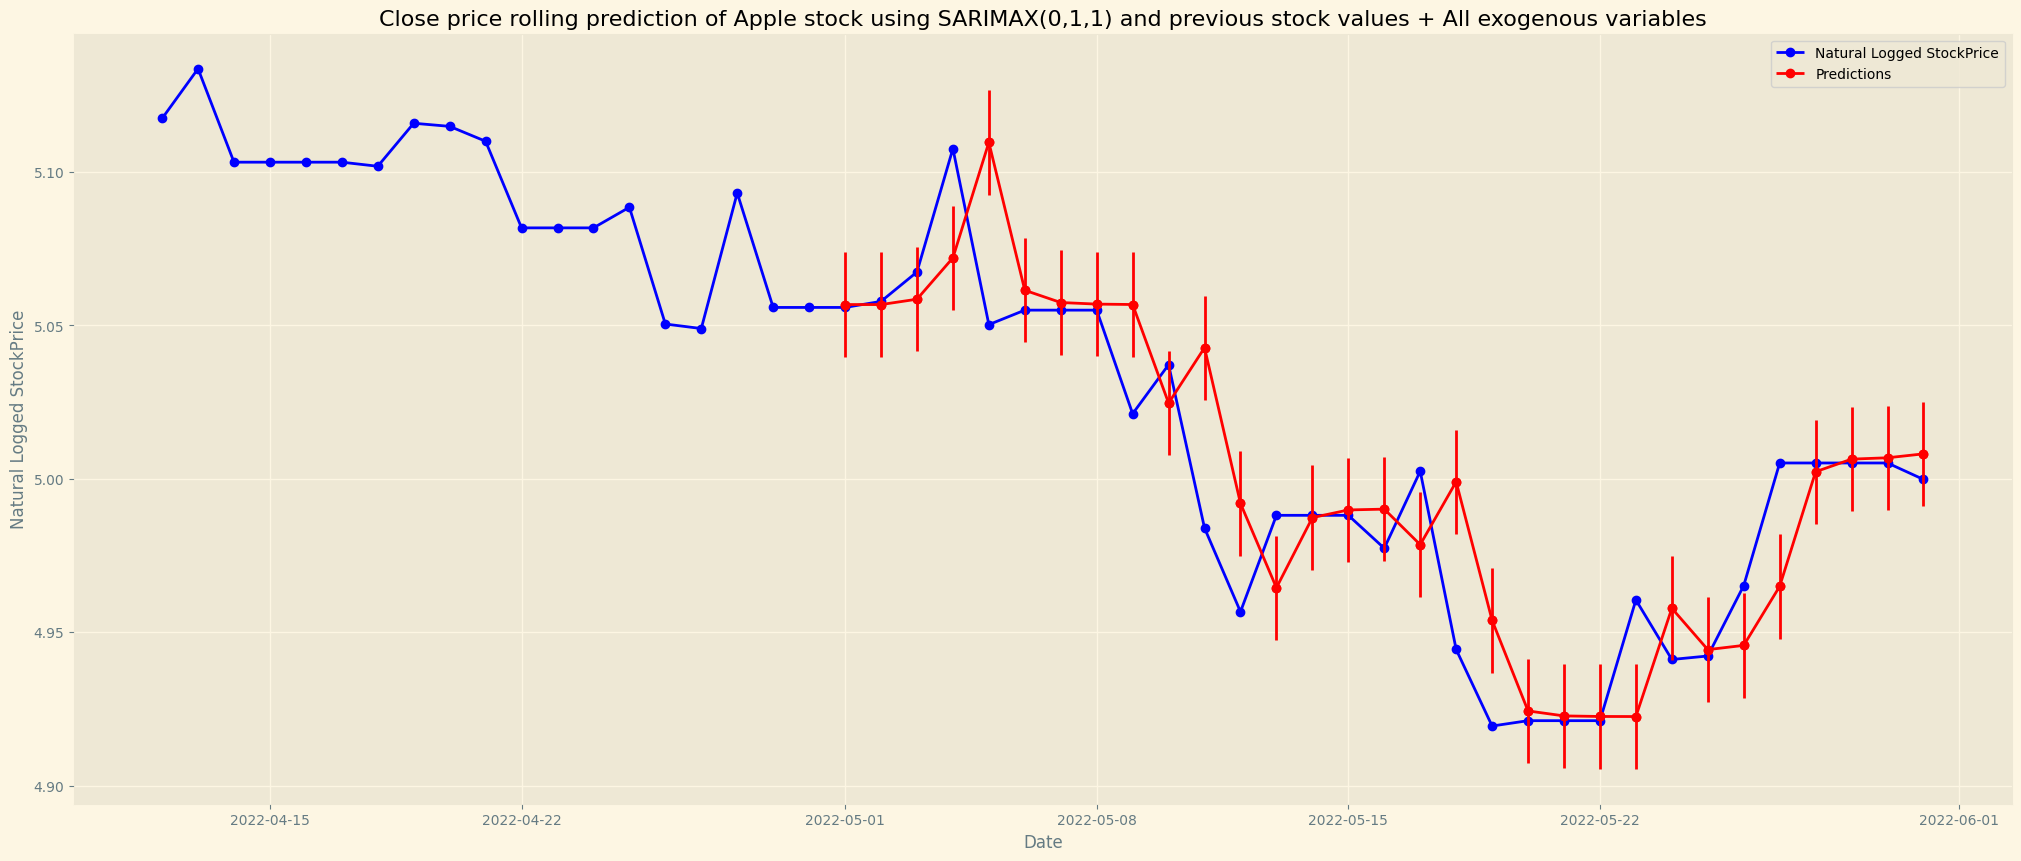

The root mean squared error is:  0.14258912285494318


In [299]:
#Close price rolling prediction of Apple stock using SARIMAX and previous stock values + All exogenous variables

trainData = stockDataResample['Close'][0:1854]
trainDataExog = exogenousdf[0:1854]  
testData = pd.DataFrame(stockDataResample['Close'][1854:])
testDataExog =  pd.DataFrame(exogenousdf[1854:])   
testData['Predictions'] = 0

for i in range(len(testData)):
    model = SARIMAX(endog=trainData,exog=trainDataExog,order=(0, 1, 1))
    modelFit = model.fit()

    futureForcast = modelFit.forecast(exog = testDataExog[i:i+1])
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    trainDataExog = trainDataExog.append(testDataExog[i:i+1])
    trainDataExog = trainDataExog[1:] 
    
    
    
    
#plot for close price prediction
plt.figure(figsize=(25,10))
plt.plot(stockDataResample['Close'][1835:],'-bo',label='Natural Logged StockPrice')
plt.plot(testData['Predictions'],'-ro',label='Predictions')

plt.errorbar(x = testData.index, y = testData['Predictions'],
             yerr = 0.017,
             fmt ='ro')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Natural Logged StockPrice")
plt.title("Close price rolling prediction of Apple stock using SARIMAX(0,1,1) and previous stock values + All exogenous variables")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))
predSave5 = testData

In [ ]:
# Section 8 #########################################################################################
#Results####################

Text(0.5, 1.0, 'Model Comparision based on Root Mean Squared Error')

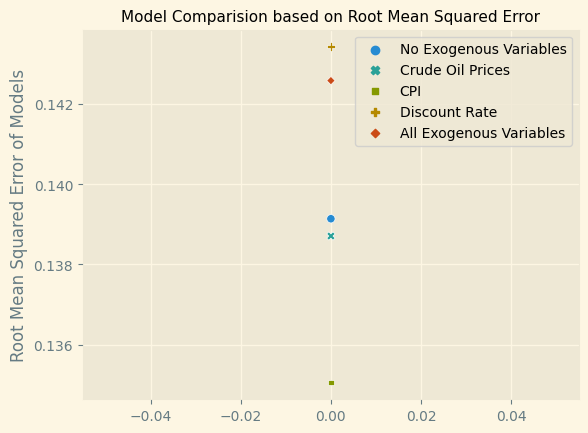

In [342]:
preformanceErrors = pd.DataFrame(np.array([0.13914120716652387,0.13871031573432804,0.13505579764578104,0.14344034627452087,0.14258912285494318]).reshape(1,-1),columns = ['No Exogenous Variables','Crude Oil Prices','CPI','Discount Rate','All Exogenous Variables'])
sns.scatterplot(preformanceErrors)
plt.ylabel("Root Mean Squared Error of Models")
plt.title("Model Comparision based on Root Mean Squared Error",fontsize=11)

Text(0.5, 1.0, 'Model Comparision based on percentage improvement')

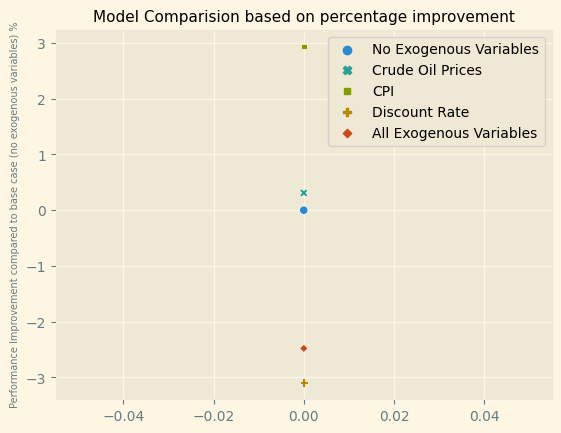

In [341]:
#plt.figure(figsize=(5,25))
sns.scatterplot(-100*(preformanceErrors-0.13914120716652387)/0.13914120716652387)
plt.ylabel("Performance Improvement compared to base case (no exogenous variables) %",fontsize=7)
plt.title("Model Comparision based on percentage improvement",fontsize=11)

In [350]:
fullData = predSave1
fullData['Crude Oil Prices'] = predSave2['Predictions']
fullData['CPI'] = predSave3['Predictions']
fullData['Discount Rate'] = predSave4['Predictions']
fullData['All Exogenous Variables'] = predSave5['Predictions']
fullData

,Close,No Exogenous Variables,Crude Oil Prices,CPI,Discount Rate,All Exogenous Variables
Date,,,,,,
2022-05-01,5.055864,5.056229,5.055537,5.056235,5.056235,5.056808
2022-05-02,5.057828,5.055902,5.055171,5.055903,5.055903,5.056795
2022-05-03,5.067405,5.057624,5.056882,5.057623,5.057623,5.058544
2022-05-04,5.107594,5.066371,5.070522,5.066362,5.066362,5.072018
2022-05-05,5.050266,5.103272,5.104858,5.108055,5.108055,5.109651
2022-05-06,5.054982,5.056043,5.057531,5.060240,5.060240,5.061452
2022-05-07,5.054982,5.055097,5.053507,5.059289,5.059289,5.057466
2022-05-08,5.054982,5.054995,5.053030,5.059114,5.059114,5.056948
2022-05-09,5.021230,5.054984,5.052938,5.059032,5.059032,5.056816


Text(0.5, 1.0, 'All predictions plotted together')

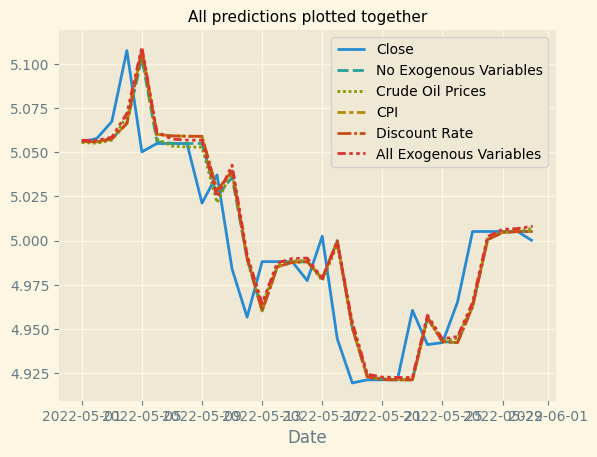

In [351]:

sns.lineplot(fullData)
plt.title("All predictions plotted together",fontsize=11)